В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import mean_squared_error
import operator
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

Area under ROC score on Train dataset: 0.87


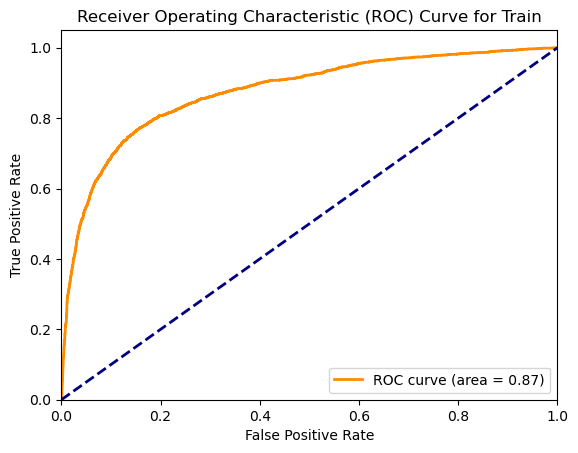

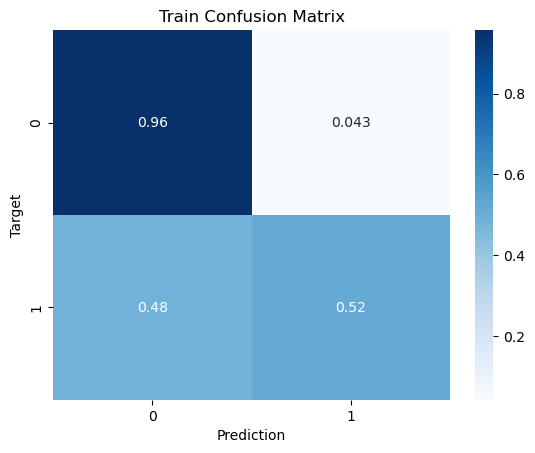

Area under ROC score on Validation dataset: 0.87


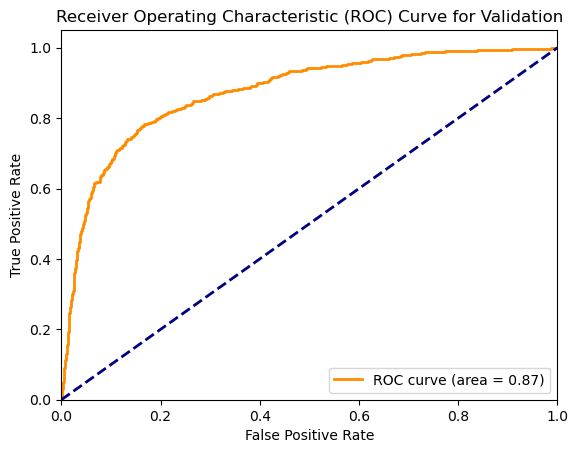

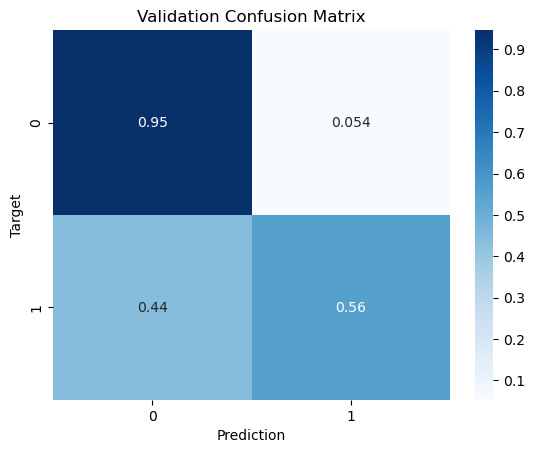

['churn_prediction_pipeline.joblib']

In [30]:
# Load the dataset
raw_df = pd.read_csv('bank-customer-churn-prediction-dlu/train.csv', index_col=0)

# Split the dataset
train_df, val_df = train_test_split(raw_df, test_size=0.20, random_state=42, stratify=raw_df['Exited'])

# Encode Geography using frequency
frequency_encoding = train_df['Geography'].value_counts(normalize=True)
raw_df['Geography_encoded'] = raw_df['Geography'].map(frequency_encoding)

# Encode Gender
gender_codes = {'Male': 1, 'Female': 0}
raw_df['Gender_Type_Code'] = raw_df['Gender'].map(gender_codes)

# Drop unnecessary columns
raw_df.drop('Surname', axis=1, inplace=True)
raw_df.drop(['Gender', 'Geography'], axis=1, inplace=True)
raw_df.drop(['CustomerId'], axis=1, inplace=True)

# Regenerate train_df and val_df
train_df, val_df = train_test_split(raw_df, test_size=0.20, random_state=42, stratify=raw_df['Exited'])

# Create training and validation sets
input_cols = list(raw_df.columns)
target_col = 'Exited'
input_cols.remove(target_col)
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()


# Create transformers for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols),
    ])

# Create pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train pipeline
model_pipeline.fit(train_inputs, train_targets)

# Function to predict and plot metrics
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    fpr, tpr, thresholds = roc_curve(targets, model_pipeline.predict_proba(inputs)[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()
    
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    
    # Plot the Confusion Matrix
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Evaluate model on train and validation data
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Save the model
joblib.dump(model_pipeline, 'churn_prediction_pipeline.joblib')

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train dataset: 0.93


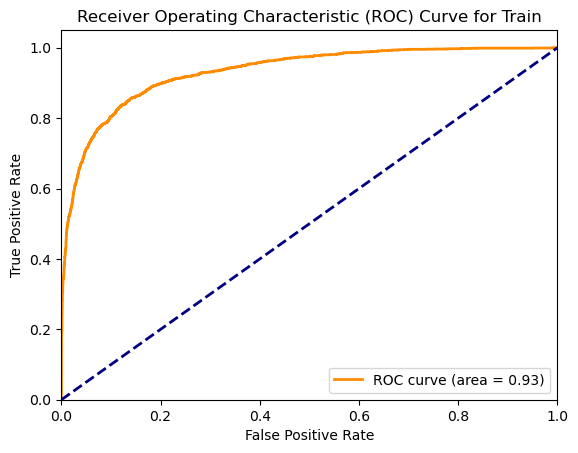

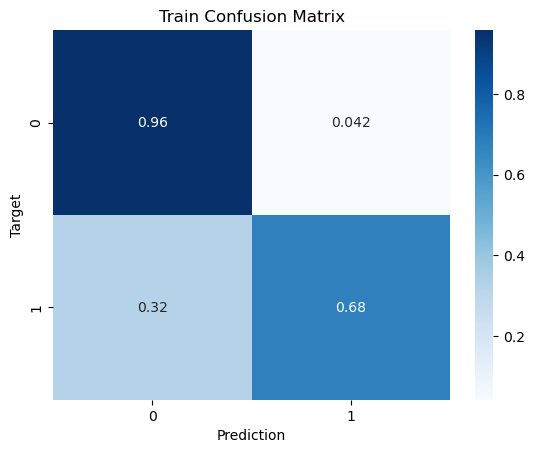

Area under ROC score on Validation dataset: 0.93


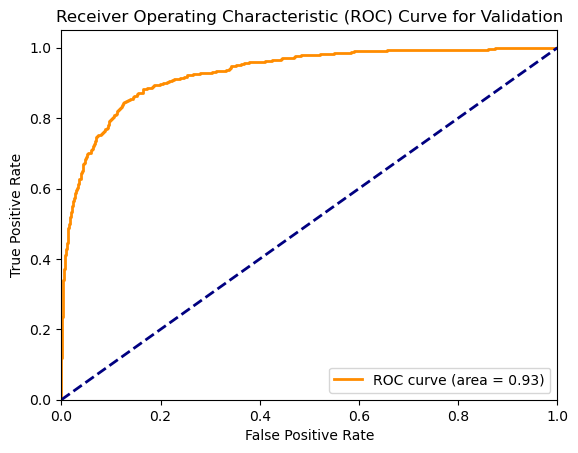

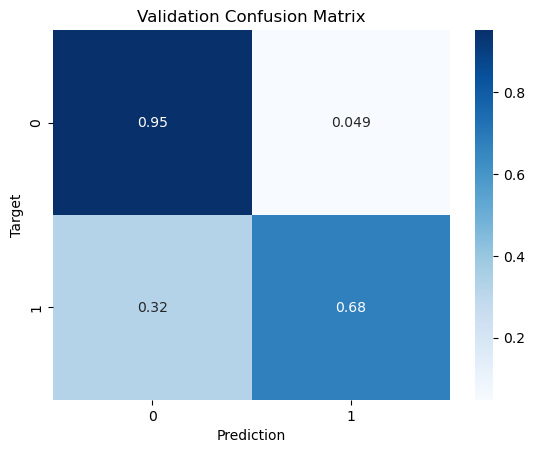

In [19]:
# Create transformers for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols),
    ])

# Create pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train pipeline
model_pipeline.fit(train_inputs, train_targets)

# Function to predict and plot metrics
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    fpr, tpr, thresholds = roc_curve(targets, model_pipeline.predict_proba(inputs)[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()
    
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    
    # Plot the Confusion Matrix
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Evaluate model on train and validation data
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

Висновок: Метрика якості модельки по ROC-curve покращилась аж до 93%, при чому на валідаційному і на навчальному наборах даних.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train dataset: 0.96


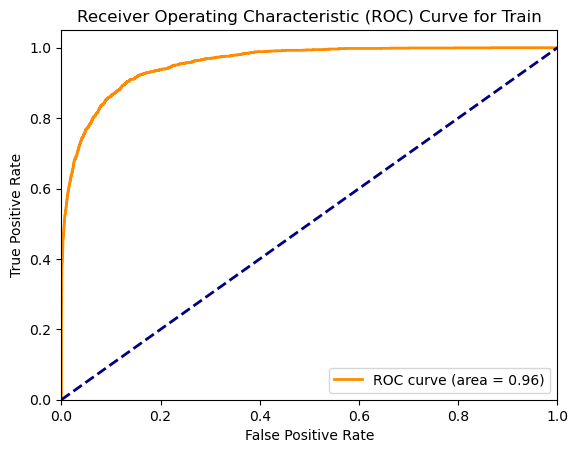

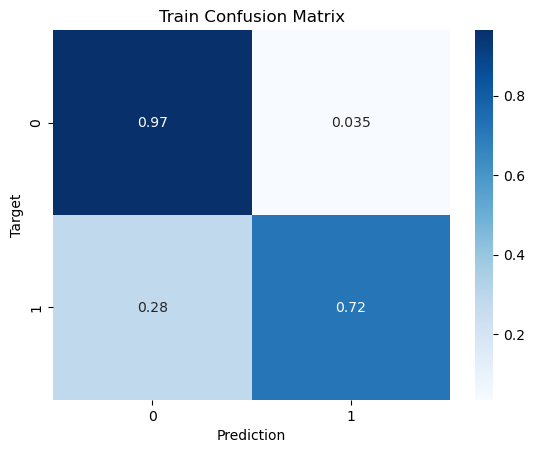

Area under ROC score on Validation dataset: 0.91


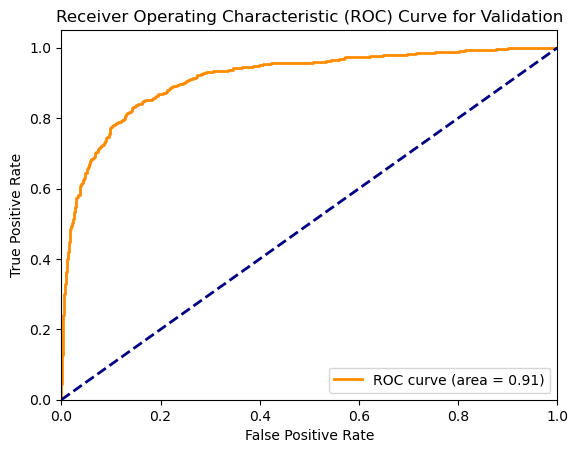

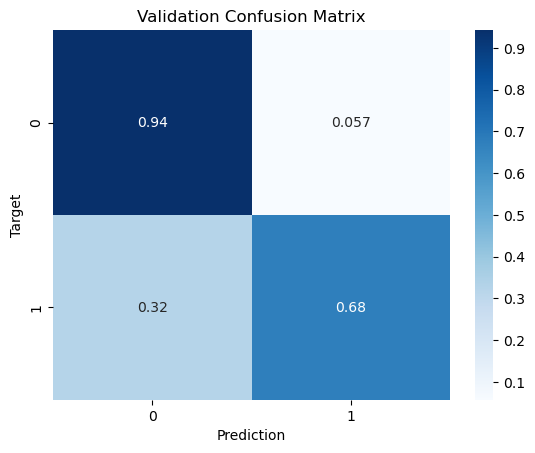

In [20]:
# Create transformers for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=4, include_bias=False))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols),
    ])

# Create pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train pipeline
model_pipeline.fit(train_inputs, train_targets)

# Function to predict and plot metrics
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    fpr, tpr, thresholds = roc_curve(targets, model_pipeline.predict_proba(inputs)[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()
    
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    
    # Plot the Confusion Matrix
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Evaluate model on train and validation data
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

Висновок: для степені 4 вже метрика якості модельки по ROC-curve на валідаційному датасеті складає 91% і це нижче, аніж на тренувальному, де метрика якості модельки по ROC-curve = 96%, що свідчить, що ми почали перенавчатись.

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [3]:
def train_lin_vs_poly_reg_and_plot(X_train, X_val, y_train, y_val, degree):
  # Звичайна лінійна регресія
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred_train_lin = lin_reg.predict(X_train)
    y_pred_val_lin = lin_reg.predict(X_val)

    # Поліноміальна регресія
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_val_poly = poly_features.transform(X_val)

    print(f'В оригіналній матриці Х {X_train.shape[1]} ознак.')
    print(f'В матриці Х з поліноміальними ознаками {X_train_poly.shape[1]} ознак.\n')

    poly_reg = LinearRegression()
    poly_reg.fit(X_train_poly, y_train)
    y_pred_train_poly = poly_reg.predict(X_train_poly)
    y_pred_val_poly = poly_reg.predict(X_val_poly)

    # Оцінка моделей

    rmse_lin_train = mean_squared_error(y_train, y_pred_train_lin, squared=False)
    rmse_poly_train = mean_squared_error(y_train, y_pred_train_poly, squared=False)

    rmse_lin_val = mean_squared_error(y_val, y_pred_val_lin, squared=False)
    rmse_poly_val = mean_squared_error(y_val, y_pred_val_poly, squared=False)


    print(f"Train RMSE for Linear Regression: {np.sqrt(rmse_lin_train):.3f}")
    print(f"Test RMSE for Linear Regression: {np.sqrt(rmse_lin_val):.3f}\n")

    print(f"Train RMSE for Polynomial Regression (degree {degree}): {np.sqrt(rmse_poly_train):.3f}")
    print(f"Test RMSE for Polynomial Regression (degree {degree}): {np.sqrt(rmse_poly_val):.3f}")

In [4]:
def gradient_descent(X_train, y_train, X_val, y_val, learning_rate, n_iterations):
    m = len(y_train)
    theta = np.random.randn(X_train.shape[1], 1)
    learning_curve_train = []
    learning_curve_val = []
    for iteration in range(n_iterations):
        gradients = 2/m * X_train.T.dot(X_train.dot(theta) - y_train)
        theta = theta - learning_rate * gradients
        y_pred = X_train.dot(theta)
        y_pred_val = X_val.dot(theta)
        train_error = mean_squared_error(y_train, y_pred, squared=False)
        val_error = mean_squared_error(y_val, y_pred_val, squared=False)
        learning_curve_train.append(train_error)
        learning_curve_val.append(val_error)
    print('Train RMSE: ', train_error)
    print('Test RMSE: ', val_error)
    return theta, learning_curve_train, learning_curve_val


def plot_learning_curve(n_iterations, learning_curve_train, learning_curve_val):
    plt.plot(range(n_iterations), learning_curve_train, 'r-', label='Training error')
    plt.plot(range(n_iterations), learning_curve_val, 'g-', label='Validation error')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve (Gradient Descent)')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


def plot_model(theta, X_train, y_train, X_val, y_val):
    plt.scatter(X_train[:, 1], y_train, color='blue', label='Train Data')
    plt.scatter(X_val[:, 1], y_val, color='orange', label='Val Data')

    # Combining X_train and X_val for plotting
    X_combined = np.concatenate((X_train, X_val), axis=0)
    X_combined_sorted_indices = np.argsort(X_combined[:, 1])
    X_combined_sorted = X_combined[X_combined_sorted_indices]

    # Making predictions with the sorted combined data
    y_pred_sorted = X_combined_sorted.dot(theta)

    plt.plot(X_combined_sorted[:, 1], y_pred_sorted, color='red', label='Model')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Model Fit')
    plt.legend()
    plt.show()
    
def fit_poly_reg(X_train, y_train, X_val, y_val, degree, learning_rate, n_iterations):
    polynomial_features = PolynomialFeatures(degree=degree)
    X_train_poly = polynomial_features.fit_transform(X_train)
    X_val_poly = polynomial_features.fit_transform(X_val)

    # Train model and plot learning curve
    theta, learning_curve_train, learning_curve_val = gradient_descent(X_train_poly, y_train, X_val_poly, y_val, learning_rate, n_iterations)
    plot_learning_curve(n_iterations, learning_curve_train, learning_curve_val)

    return X_train_poly, X_val_poly, theta

In [9]:
# Load the dataset
raw_df = pd.read_csv('regression_data.csv')

# Split the dataset
train_df, val_df = train_test_split(raw_df, test_size=0.20, random_state=42)

# Create training and validation sets
input_cols = list(raw_df.columns)
target_col = 'target'
input_cols.remove(target_col)
X_train, y_train = train_df[input_cols].copy(), train_df[target_col].copy()
X_val, y_val = val_df[input_cols].copy(), val_df[target_col].copy()

In [10]:
degree = 2
train_lin_vs_poly_reg_and_plot(X_train, X_val, y_train, y_val, degree)

В оригіналній матриці Х 5 ознак.
В матриці Х з поліноміальними ознаками 21 ознак.

Train RMSE for Linear Regression: 1.033
Test RMSE for Linear Regression: 0.940

Train RMSE for Polynomial Regression (degree 2): 1.008
Test RMSE for Polynomial Regression (degree 2): 1.007


Train RMSE:  1.7287807565866393
Test RMSE:  2.0704858944533


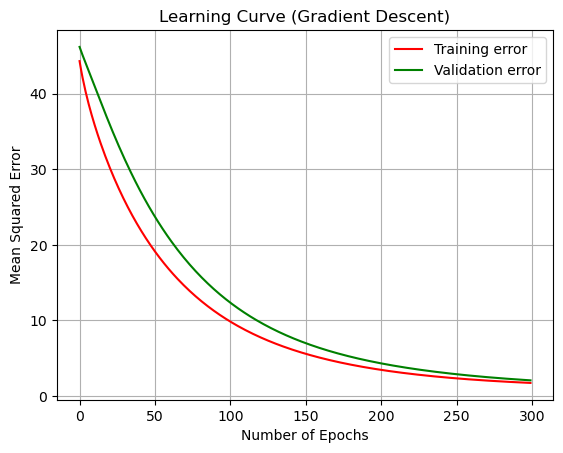

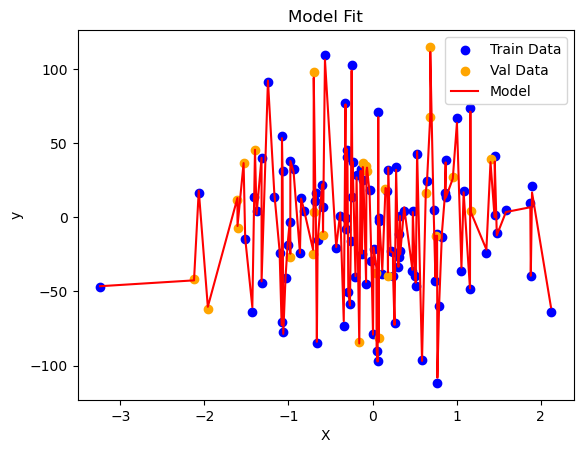

In [11]:
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)

X_train_poly, X_val_poly, theta = fit_poly_reg(X_train, y_train, X_val, y_val, degree=2, learning_rate=0.01, n_iterations=300)
plot_model(theta, X_train_poly, y_train, X_val_poly, y_val)

Train RMSE:  3.821958885831054e+63
Test RMSE:  4.275077676624956e+62


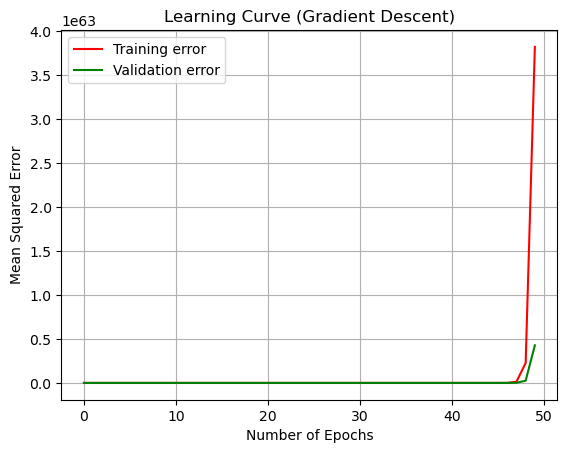

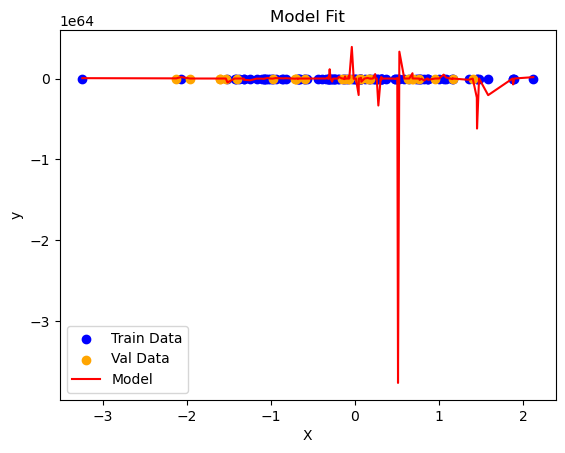

In [13]:
X_train_poly, X_val_poly, theta = fit_poly_reg(X_train, y_train, X_val, y_val, degree=5, learning_rate=0.001, n_iterations=50)
plot_model(theta, X_train_poly, y_train, X_val_poly, y_val)

In [14]:
degree = 5
train_lin_vs_poly_reg_and_plot(X_train, X_val, y_train, y_val, degree)

В оригіналній матриці Х 5 ознак.
В матриці Х з поліноміальними ознаками 252 ознак.

Train RMSE for Linear Regression: 1.033
Test RMSE for Linear Regression: 0.940

Train RMSE for Polynomial Regression (degree 5): 0.000
Test RMSE for Polynomial Regression (degree 5): 5.425


Висновок: Якщо подивитись на RMSE моделі для степені 2, помилка маленька, але для натренованої модельки в 5 степені помилки на навчальних даних взагалі немає, в той час як на тестових вони немала, тому можна сказати, що моделька побудована на поліномі в 5 степені погано генералізована і перенавчена на навчальних даних.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лог регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [15]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    LinearRegression(),
    Ridge(),
    Ridge(alpha=2),
    Lasso(),
    ElasticNet(),
    ElasticNet(alpha=0.5)
]

In [16]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_metrics = mean_squared_error(y_train, y_train_pred, squared=False).round(6)
    val_metrics = mean_squared_error(y_val, y_val_pred, squared=False).round(6)

    return dict(train=train_metrics, val=val_metrics)

In [17]:
poly_features = PolynomialFeatures(degree=20)
X_train_poly = poly_features.fit_transform(X_train)
X_val_poly = poly_features.transform(X_val)

In [18]:
import warnings

warnings.filterwarnings("ignore")

for model in models:
    model.fit(X_train_poly, y_train)
    eval_results  = evaluate_model(model, X_train_poly, y_train, X_val_poly, y_val)
    print(f'{str(model)}: {eval_results}\n')

LinearRegression(): {'train': 0.00497, 'val': 102877.790257}

Ridge(): {'train': 31.55401, 'val': 12163.844617}

Ridge(alpha=2): {'train': 31.55401, 'val': 12163.844617}

Lasso(): {'train': 2.313505, 'val': 68.318791}

ElasticNet(): {'train': 10.159852, 'val': 1526.820921}

ElasticNet(alpha=0.5): {'train': 7.741732, 'val': 1083.402468}



Висновок: Бачимо, що найкраще справляється модель з регуляризацією по Lasso, де помилка на тренувальному датасеті невелика в той час як на валідаційному становить аж 68. Так як Лассо може занулювати деякі коефіцієнти перед ознаками, тому ця регуляризація впоралася тут найбільше. Тобто скоріше за все тут відбулось досить сильне перенавчання модельки на тренувальних даних. Звичайно, що моделька з поліномом в 5 степені у попередньому завданні має меншу степінь перенавчання і працює краще.